In [127]:
import sys
sys.path.append('../')
sys.path.append('../support/')
sys.path.append('../Nets/')
sys.path.append('../lung_segmentation/')
from glob import glob
import timeit
from skimage.transform import resize
from os.path import join, basename, isfile
from scipy.ndimage.interpolation import rotate
from tqdm import tqdm
from functools import partial
from paths import *
from ct_reader import *
from lung_separation import *
import csv
import dicom
from matplotlib import pyplot as plt
from scipy.misc import imresize
from skimage import exposure
from sklearn.decomposition import PCA
from paths import *
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from ResNet import *
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [128]:
def load_mask(path):
    if len(path.split('.mhd')) == 2:
        return load(join(PATH['LUNA_OUT'], basename(path).split('.mhd')[0] + '.npy'))
    else:
        return load(join(PATH['DATA_OUT'], basename(path) + '.npy'))

In [129]:
def read_ct(path, ret_xy_spacing=False):
    patient = read_ct_scan(path)
    image = get_pixels_hu(patient)
    
    if ret_xy_spacing:
        return image, patient.GetSpacing()[0]
    
    return image

In [130]:
def crop_lungs(lungs, mask):
    mask[(mask == 4) 
         | (mask == 12) 
         | (mask == 8)] = 0

    mask[(mask == 1) 
         | (mask == 5) 
         | (mask == 9)
         | (mask == 13)] = 1

    mask[(mask 
== 2) 
         | (mask == 6) 
         | (mask == 10)
         | (mask == 14)] = 1

    mask[(mask == 3) 
         | (mask == 7) 
         | (mask == 15)] = 0
    
    x, y, z = where(mask)
    if ((unique(x.shape[0]).shape[0] < 20) or 
        (unique(x.shape[1]).shape[0] < 20) or 
        (unique(x.shape[2]).shape[0] < 20)):
        return lungs[lungs.shape[0] // 2 - int(lungs.shape[0] * .35): 
                     lungs.shape[0] // 2 + int(lungs.shape[0] * .25), 
                     lungs.shape[1] // 2 - int(lungs.shape[1] * .35): 
                     lungs.shape[1] // 2 + int(lungs.shape[1] * .25), 
                     lungs.shape[2] // 2 - int(lungs.shape[2] * .35): 
                     lungs.shape[2] // 2 + int(lungs.shape[2] * .25)]
    min_x, min_y, min_z = min(x), min(y), min(z)
    max_x, max_y, max_z = max(x), max(y), max(z)
    return lungs[min_x: max_x, 
                 min_y: max_y, 
                 min_z: max_z]

In [131]:
def get_extractor():
    model, bottle_neck = ResNet50()
    bottle_neck = load_weighs(bottle_neck, include_top=False)
    return bottle_neck

In [132]:
def select_slice(patient, i, axes=0):
    if axes == 0:
        return patient[i]
    if axes == 1:
        return patient[:, i]
    if axes == 2:
        return patient[:, :, i]
    

In [133]:
def get_data(path, axes=0):
    patient = read_ct(path)
    mask = load_mask(path)
    patient = crop_lungs(patient, mask)
    patient = clip(patient, -1000, 400)
    batch = list()
    for i in range(0, patient.shape[axes] - 9, 3):
        tmp = list()
        for j in range(3):
            
            img = select_slice(patient, i + 3 * j, axes)
        
            for k in range(1, 3):
                img = vstack([expand_dims(select_slice(patient, 
                                                       i + j + 3 * j, 
                                                       axes), 
                                          0), 
                              expand_dims(img, 0)]).max(axis=0)
                
            img = 255.0 / amax(img) * img
#             img = exposure.equalize_hist(img.astype(np.uint8))
            img = imresize(img, 
                           (224, 224), 
                           interp='bicubic')
            tmp.append(img)

        batch.append(array(tmp))

    return array(batch)

In [78]:
imshow(swapaxes(swapaxes(c[19], 0, 2), 1, 0));

NameError: name 'c' is not defined

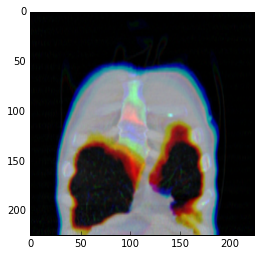

In [107]:
imshow(swapaxes(swapaxes(c[4], 0, 2), 1, 0));

In [122]:
def calc_features(patients, net=None, batch_size=32, post_dir='MAX_TOP', axes=0):
    if net is None:
        net = get_extractor()
        
    for folder in tqdm(patients):
        batch = get_data(folder, axes=axes)
        feats = list()
        for i in range(len(batch) // batch_size + 1):
            tmp = net.predict(swapaxes(
                    swapaxes(batch[i * batch_size: 
                                   (i + 1) * batch_size], 
                             1, 3), 1, 2))
            if len(tmp):
                feats.append(tmp)
        feats = vstack(feats)
        save(join(PATH['DATA_MXNET'], 
                  post_dir, 
                  basename(folder)), 
             feats)

In [123]:
def get_remined_files(post_dir='MAX_TOP'):
    file_list = set(basename(path) 
                    for path in glob(join(PATH['DATA'], '*')))

    file_list = file_list.difference([basename(path).split('.npy')[0] 
                                      for path in glob(join(PATH['DATA_MXNET'], 
                                                            post_dir, '*.npy'))])
    file_list = [join(PATH['DATA'], base_name) 
                 for base_name in file_list]
    return file_list


In [81]:
# net = get_extractor()

K.image_dim_ordering: tf


In [ ]:
file_list = get_remined_files()
while len(file_list):
#     try:
        calc_features(file_list, net, 
                      batch_size=32, 
                      post_dir='MAX_TOP', 
                      axes=0)
        file_list = get_remined_files(post_dir='MAX_TOP')
        
#     except:
#         pass
#         continue


100%|██████████| 943/943 [2:51:02<00:00, 12.26s/it]


In [135]:
file_list = get_remined_files(post_dir='MAX_FRONT')
while len(file_list):
#     try:
        calc_features(file_list, net, 
                      batch_size=32, 
                      post_dir='MAX_FRONT', 
                      axes=1)
        file_list = get_remined_files(post_dir='MAX_FRONT')
        
#     except:
#         pass
#         continue


100%|██████████| 841/841 [1:27:25<00:00,  3.83s/it]


In [11]:
def to_dataframe(stats):
    columns = ['id', 'max', 
               'amoun', 'mean', 
               'median_not_min', 
               'mean_not_min', 
               'std', 'areas', 
               'median'] + ['modes_' + str(i) 
                            for i in range(9)]

    df = pd.DataFrame(None, columns=columns)
    
    for isolated in tqdm(stats):
        tmp = dict()
        if 'modes' in  isolated[1].keys():
            isolated[1]['modes'] = [sum(threshold)
                                    for threshold in isolated[1]['modes']]
        else: 
            isolated[1]['modes'] = [0] * 9
            
        for i in range(9):
            tmp['modes_' + str(i)] = [isolated[1]['modes'][i]]
        tmp['id'] = isolated[0]
        tmp['areas'] = [sum(isolated[1]['areas'])]
        remind = set(isolated_stats[0][1].keys())
        remind = remind.difference(['modes', 'areas'])
        for key in remind:
            tmp[key] = [isolated[1][key]]
        df = df.append(pd.DataFrame(tmp))
    return df

In [12]:
isolated_stats = pickle.load(open(join(PATH['DATA_OUT'], 'isolated_stats'), 'rb'))
vascular_stats = pickle.load(open(join(PATH['DATA_OUT'], 'vascular_stats'), 'rb'))
plural_stats = pickle.load(open(join(PATH['DATA_OUT'], 'plural_stats'), 'rb'))

In [13]:
df_isolated = to_dataframe(isolated_stats)
df_vascular = to_dataframe(vascular_stats)
df_plural = to_dataframe(plural_stats)

100%|██████████| 1453/1453 [00:06<00:00, 235.86it/s]


In [341]:
df = df_isolated.merge(df_vascular, 
                       left_on='id', 
                       right_on='id', 
                       how='outer')
# df = df.merge(df_plural, 
#               left_on='patient', 
#               right_on='patient', 
#               how='outer')
df.to_csv(join(PATH['WEIGHTS'], 'dataframe_stats'))

In [355]:
def extract_enhs(df_features, df_labels=None):
    if df_labels is not None:
        df_features['cancer'] = NaN
        for row in df_labels.iterrows():
            df_features.loc[df_features['id'] == row[1]['id'], 'cancer'] = row[1].cancer
        df_features.dropna(inplace=True)
        return df_features.drop(['cancer', 'id'], axis=1), df_features.cancer
    else:
        return df_features.drop(['id'], axis=1), df_features['id']

In [306]:
def extract_mxnet(df=None, mxnet='MAX_TOP'):
    x = [[load(join(PATH['DATA_MXNET'], mxnet, 
                    '%s.npy' % str(patient))).reshape(-1, 2048)] 
         for patient in df['id'].tolist()]

    coords = [0]
    for el in x:
        coords.append(el[0].shape[0] + coords[-1])

    x = vstack([el[0] for el in x])

    features = list()
    for i in range(1, len(coords)):
        features.append(mean(x[coords[i - 1]: coords[i]], axis=0))

    features = vstack(features)
#     features = PCA(60).fit_transform(features)
    
    x = [load(join(PATH['DATA_ENHANCED'], 
                    '%samounts.npy' % str(patient))) 
         for patient in df['id'].tolist()]
    features = hstack([features, x])
    
    if 'cancer' in df.columns:
        return features, df['cancer']
    else:
        return features

In [404]:
def extract_luna(mxnet='CASUAL'):
    df = pd.read_csv(PATH['LABELS'])
    print(df.head())

    features = np.array([mean(load(join(PATH['DATA_MXNET'], mxnet, 
                                        '%s.npy' % str(patient))).reshape(-1, 2048), axis=0) 
                         for patient in df['id'].tolist()])
    
    y = df['cancer'].as_matrix()
    
    df = pd.read_csv(join(PATH['LUNA_CSV'], 
                          'annotations.csv'))
    cancer = df['seriesuid'].unique()
    file_list = [path for path in glob(join(PATH['LUNA_MXNET'], '*.npy'))]
    luna_x = asarray([mean(load(path).reshape(-1, 2048), axis=0)
                      for path in file_list])
    luna_y = asarray([1 if basename(path).split('.npy')[0] in cancer else 0 
                      for path in file_list])

    x = vstack([luna_x, x])
    y = hstack([luna_y, y])
    
    return features, y

In [311]:
def train_xgboost(df_mxnet=None, df_enhs=None, mxnet='CASUAL'):
    if df_enhs is not None:
        features, y = extract_enhs(df_enhs, pd.read_csv(PATH['LABELS']))
    if df_mxnet is not None:
        features_, y_ = extract_mxnet(df_mxnet, mxnet)

    trn_x, val_x, trn_y, val_y = train_test_split(features, y, 
                                                  random_state=42, 
                                                  stratify=y,
                                                  test_size=.2)

    print(trn_x.shape, trn_y.shape)
    clf = xgb.XGBClassifier(max_depth=9,
                            n_estimators=20000,
#                             min_child_weight=2,
                            learning_rate=0.001,
                            max_delta_step=1,
                            nthread=8,
                            subsample=0.80,
                            colsample_bytree=0.90,
                            seed=4242)

    clf.fit(trn_x, trn_y, 
            eval_set=[(val_x, val_y)], 
            verbose=200, 
            eval_metric='logloss', 
            early_stopping_rounds=200)
    return clf

In [347]:
def train_xgboost(df=None, mxnet='CASUAL', enh_mode=True):
    if enh_mode:
        features, y = extract_enhs(df, pd.read_csv(PATH['LABELS']))
    else:
        features, y = extract(df, mxnet)

    trn_x, val_x, trn_y, val_y = train_test_split(features, y, 
                                                  random_state=42, 
                                                  stratify=y,
                                                  test_size=.2)

    print(trn_x.shape, trn_y.shape)
    clf = xgb.XGBClassifier(max_depth=9,
                            n_estimators=20000,
#                             min_child_weight=2,
                            learning_rate=0.001,
#                             max_delta_step=1,
                            scale_pos_weight=.7,
                            nthread=8,
                            subsample=0.80,
                            colsample_bytree=0.90,
                            seed=4242)

    clf.fit(trn_x, trn_y, 
            eval_set=[(val_x, val_y)], 
            verbose=200, 
            eval_metric='logloss', 
            early_stopping_rounds=200)
    return clf

In [401]:
def make_submit():
    df = pd.read_csv(join(PATH['WEIGHTS'], 
                          'dataframe_stats')).drop(['Unnamed: 0'], axis=1)
    clf = train_xgboost(df, enh_mode=True)
    df = pd.read_csv(join(PATH['WEIGHTS'], 
                          'dataframe_stats')).drop(['Unnamed: 0'], axis=1)
    df_sample = pd.read_csv(PATH['SAMPLE'])
    
    df = df.merge(df_sample.drop(['cancer'], axis=1), 
                  left_on='id', right_on='id')
    
    x, ids = extract_enhs(df)
    pred = clf.predict(x)
    for idx, pred_value in zip(ids, pred):
        df_sample.loc[df_sample['id'] == idx, 'cancer'] = pred_value
        
#     df_sample.loc[df_sample.cancer == .5, 'cancer'] = 1
    df_sample.to_csv(join(PATH['CSV'], 's11.csv'), index=False)
    print(df_sample.head())
    return df_sample

In [402]:
a = make_submit()

(1016, 34) (1016,)
[0]	validation_0-logloss:0.692857
Will train until validation_0-logloss hasn't improved in 200 rounds.
[200]	validation_0-logloss:0.644567
[400]	validation_0-logloss:0.613686
[600]	validation_0-logloss:0.593494
[800]	validation_0-logloss:0.580261
[1000]	validation_0-logloss:0.572051
[1200]	validation_0-logloss:0.567533
[1400]	validation_0-logloss:0.565103
[1600]	validation_0-logloss:0.563663
[1800]	validation_0-logloss:0.563039
Stopping. Best iteration:
[1776]	validation_0-logloss:0.562973

                                 id  cancer
0  026470d51482c93efc18b9803159c960     0.0
1  031b7ec4fe96a3b035a8196264a8c8c3     0.0
2  03bd22ed5858039af223c04993e9eb22     0.0
3  06a90409e4fcea3e634748b967993531     0.0
4  07b1defcfae5873ee1f03c90255eb170     0.5


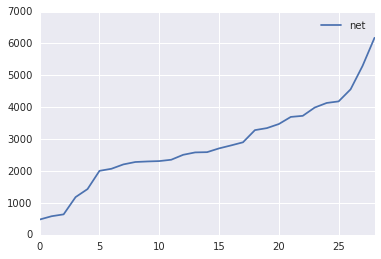

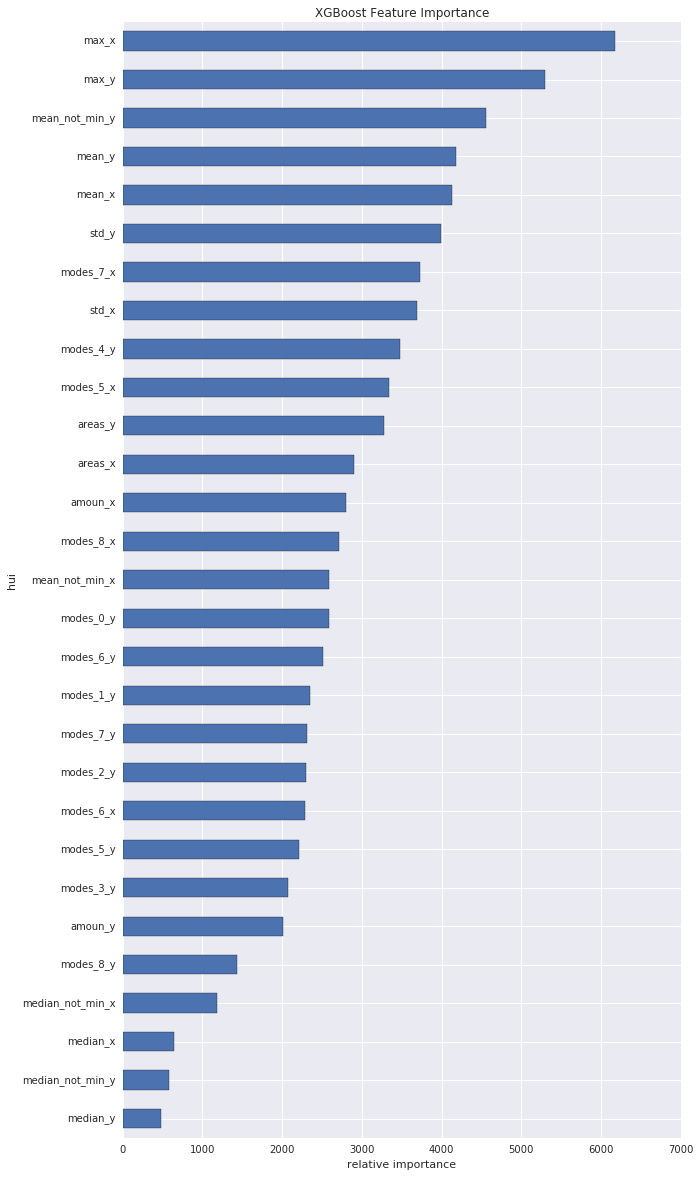

In [274]:
s_list = sorted(clf.booster().get_fscore().items(), key=lambda x: x[1])
df = pd.DataFrame({'hui':[a[0] for a in s_list],'net':[a[1] for a in s_list]})
plt.figure()
df.plot()
df.plot(kind='barh', x='hui', y='net', legend=False, figsize=(10, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [85]:
df = pd.read_csv(join(PATH['LUNA_CSV'], 'annotations.csv'))

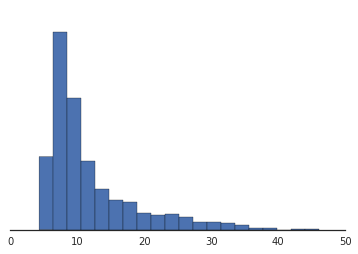

In [87]:
sns.set_style('white')
hist(df.diameter_mm.values / .7, 20, [3 / .7, df.diameter_mm.values.max() / .7], align='mid');
gca().axes.get_yaxis().set_visible(False)
sns.despine(left=True)

In [ ]:
import pickle
erroneus = set(pickle.load(open(join(PATH['WEIGHTS'], 'erroneus'), 'rb')))
erroneus = erroneus.difference(pickle.load(open(join(PATH['WEIGHTS'], 'still_erroneus'), 'rb')))

In [82]:
from scipy.spatial.distance import cdist
batch_size = 1000
middle = 32
side =64
border = 14
nodules = glob(join(PATH['LUNA_NODULES'], 'subset9', '*'))
nodules = [load(path)[middle] 
           for path in nodules]
nearests = list()
for i, nodule in enumerate(reversed(nodules[:-57])):
    print(len(nodules) - i)
    vessels_path = glob(join(PATH['LUNA_VESSELS'], 
                             'subset7', '*'))
    min_dist = 1e12
    for counter in tqdm(range(len(vessels_path) // batch_size + 1)):
        vessels = [load(path)[middle] 
                   for path in vessels_path[batch_size * counter:
                                            batch_size * (counter + 1)]]
        dists = cdist([nodule[border: side - border, 
                              border: side - border].flatten()], 
                      [i[border: side - border, 
                         border: side - border].flatten() 
                       for i in vessels])
        
        curr_min_dist = dists.min()
        if curr_min_dist < min_dist:
            min_dist = curr_min_dist
            nearest = vessels[argmin(dists)]
    nearests.append(nearest)

125


100%|██████████| 56/56 [01:24<00:00,  1.77s/it]


124


100%|██████████| 56/56 [01:21<00:00,  1.27s/it]


123


100%|██████████| 56/56 [01:29<00:00,  1.25s/it]


122


100%|██████████| 56/56 [01:21<00:00,  1.28s/it]


121


100%|██████████| 56/56 [01:25<00:00,  1.27s/it]


120


100%|██████████| 56/56 [01:25<00:00,  1.24s/it]


119


100%|██████████| 56/56 [01:23<00:00,  1.22s/it]


118


100%|██████████| 56/56 [01:23<00:00,  1.25s/it]


117


100%|██████████| 56/56 [01:21<00:00,  1.24s/it]


116


100%|██████████| 56/56 [01:26<00:00,  1.25s/it]


115


100%|██████████| 56/56 [01:29<00:00,  1.28s/it]


114


100%|██████████| 56/56 [01:21<00:00,  1.29s/it]


113


100%|██████████| 56/56 [01:21<00:00,  1.23s/it]


112


100%|██████████| 56/56 [01:26<00:00,  1.34s/it]


111


100%|██████████| 56/56 [01:23<00:00,  1.39s/it]


110


100%|██████████| 56/56 [01:20<00:00,  1.26s/it]


109


100%|██████████| 56/56 [01:23<00:00,  1.21s/it]


108


100%|██████████| 56/56 [01:21<00:00,  1.25s/it]


107


100%|██████████| 56/56 [01:30<00:00,  1.26s/it]


106


100%|██████████| 56/56 [01:23<00:00,  1.22s/it]


105


100%|██████████| 56/56 [01:21<00:00,  1.24s/it]


104


100%|██████████| 56/56 [01:23<00:00,  1.23s/it]


103


100%|██████████| 56/56 [01:24<00:00,  1.27s/it]


102


 91%|█████████ | 51/56 [01:18<00:07,  1.45s/it]

KeyboardInterrupt: 

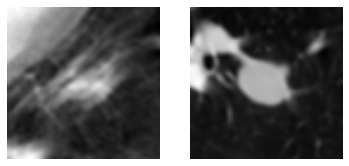

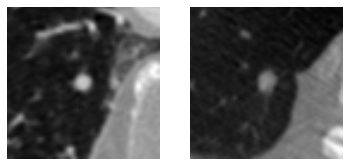

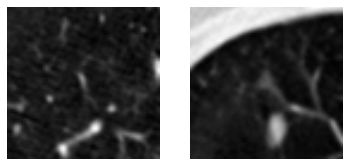

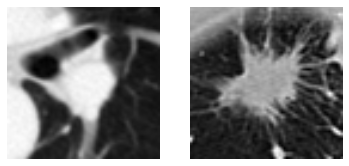

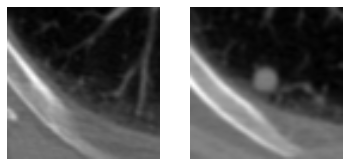

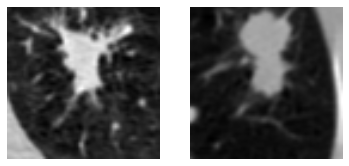

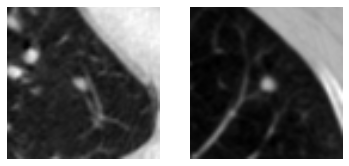

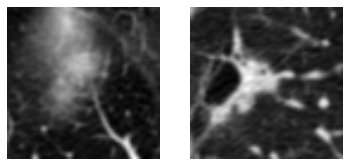

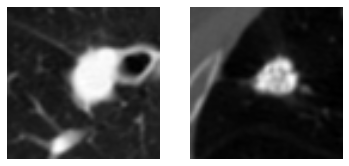

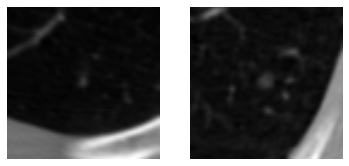

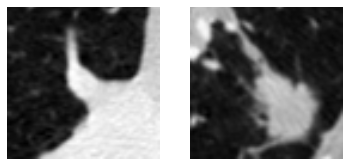

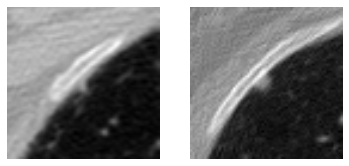

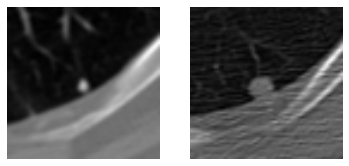

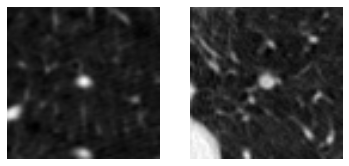

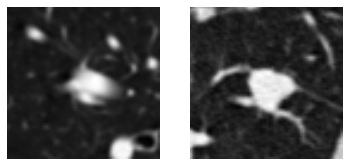

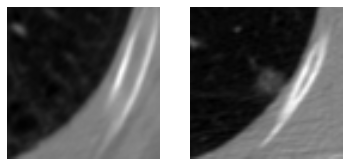

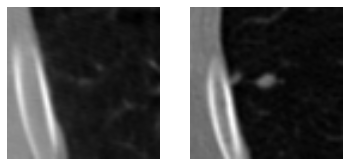

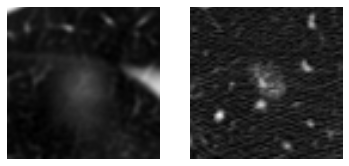

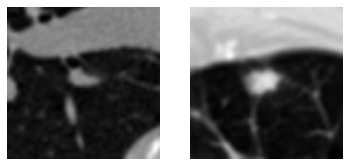

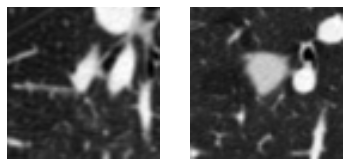

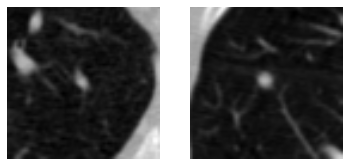

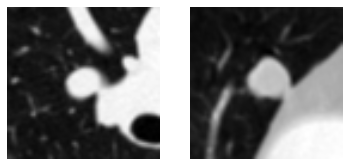

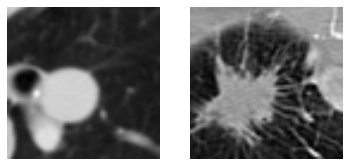

In [83]:
for nodule, near in zip(nearests, reversed(nodules[:-57])):
    subplot(1, 2, 1)
    imshow(nodule)
    gca().axes.get_yaxis().set_visible(False)
    gca().axes.get_xaxis().set_visible(False)
    subplot(1, 2, 2)
    imshow(near)
    gca().axes.get_yaxis().set_visible(False)
    gca().axes.get_xaxis().set_visible(False)
    show()